In [27]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import time
import random

def download_reports():
    # Create a session
    session = requests.Session()

    # Set up headers
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Referer': 'https://www.fire.ca.gov/',
    }

    # Step 1: Fetch the updates page
    updates_url = 'https://www.fire.ca.gov/incidents/2025/1/7/eaton-fire/updates'
    print(f"Fetching URL: {updates_url}")
    response = session.get(updates_url, headers=headers)
    response.raise_for_status()

    # Step 2: Parse the updates page to find report links
    soup = BeautifulSoup(response.text, 'html.parser')
    print("Page title:", soup.title.string if soup.title else "No title found")

    report_links = soup.select('a[href*="/incidents/"]')
    print(f"Found {len(report_links)} potential report links")

    if len(report_links) == 0:
        print("HTML content:")
        print(soup.prettify()[:1000])  # Print first 1000 characters of HTML
        return

    # Create a directory to store HTML files
    os.makedirs('eaton_html_files', exist_ok=True)

    # Step 3: Download each report
    for i, link in enumerate(report_links):
        report_url = 'https://www.fire.ca.gov' + link['href'] if link['href'].startswith('/') else link['href']
        print(f"Downloading report from: {report_url}")

        try:
            report_response = session.get(report_url, headers=headers)
            report_response.raise_for_status()

            with open(f'eaton_html_files/report_{i}.html', 'w', encoding='utf-8') as f:
                f.write(report_response.text)

            print(f"Successfully downloaded report {i+1}")
        except requests.HTTPError as e:
            print(f"Failed to download report {i+1}: {str(e)}")

        time.sleep(random.uniform(2, 5))  # Random delay between 2 and 5 seconds

    print(f"Attempted to download {len(report_links)} reports.")

# Run the function
download_reports()


Fetching URL: https://www.fire.ca.gov/incidents/2025/1/7/eaton-fire/updates
Page title: Eaton Fire Status Update Reports | CAL FIRE
Found 101 potential report links
Successfully downloaded report 1
Successfully downloaded report 2
Successfully downloaded report 3
Successfully downloaded report 4
Successfully downloaded report 5
Successfully downloaded report 6
Successfully downloaded report 7
Successfully downloaded report 8
Successfully downloaded report 9
Successfully downloaded report 10
Successfully downloaded report 11
Successfully downloaded report 12
Successfully downloaded report 13
Successfully downloaded report 14
Successfully downloaded report 15
Successfully downloaded report 16
Successfully downloaded report 17
Successfully downloaded report 18
Successfully downloaded report 19
Successfully downloaded report 20
Successfully downloaded report 21
Successfully downloaded report 22
Successfully downloaded report 23
Successfully downloaded report 24
Successfully downloaded repo

This code works to pull the update report.

In [28]:
"""
Works to parse the data and make the dataframe
"""

import os
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

fire = "eaton"

def extract_data_from_html(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file.read(), 'html.parser')

    data = {}

    # Extract date and time
    main_content = soup.find('main', id='main-content')
    if main_content:
        date_time_dl = main_content.find('dl', class_='mb-0')
        if date_time_dl:
            date_dd = date_time_dl.find('dd', string=lambda text: text and '/' in text)
            time_dd = date_time_dl.find_all('dd')[-1]  # Assume the last dd is the time
            if date_dd:
                data['Date'] = date_dd.text.strip()
            if time_dd:
                data['Time'] = time_dd.text.strip()

    # Extract incident facts
    incident_facts = soup.find('div', class_='border border-danger-dark mt-4')
    if incident_facts:
        dl_tags = incident_facts.find_all('dl', class_='row')
        for dl in dl_tags:
            dt_tags = dl.find_all('dt')
            dd_tags = dl.find_all('dd')
            for dt, dd in zip(dt_tags, dd_tags):
                key = dt.text.strip()
                value = dd.text.strip()
                data[key] = value

    # Extract assigned resources
    assigned_resources = soup.find('h2', string='Assigned Resources')
    if assigned_resources:
        resources_div = assigned_resources.find_parent('div', class_='border border-danger-dark mt-4')
        if resources_div:
            dl_tags = resources_div.find_all('dl', class_='row')
            for dl in dl_tags:
                dt_tags = dl.find_all('dt')
                dd_tags = dl.find_all('dd')
                for dt, dd in zip(dt_tags, dd_tags):
                    key = dt.text.strip()
                    value = dd.text.strip()
                    data[key] = value

    return data


def process_all_html_files(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.html'):
            file_path = os.path.join(directory, filename)
            data = extract_data_from_html(file_path)
            all_data.append(data)

    return pd.DataFrame(all_data)

# Process all HTML files in the 'html_files' directory
df = process_all_html_files(f'{fire}_html_files')

# Convert Date and Time columns to datetime if they exist
if 'Date' in df.columns and 'Time' in df.columns:
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%m/%d/%Y %I:%M %p', errors='coerce')
    df = df.sort_values('DateTime', ascending=False)

# Display the DataFrame
print(df)
df['Size'] = df['Size'].replace(',', '', regex=True).astype(float).astype('Int64')


# Optionally, save the DataFrame to a CSV file
df.to_csv(f'{fire}_fire_incident_data.csv', index=False)


          Date     Time        Name Start Date/Time Incident Status  \
99  01/11/2025  3:34 PM  Eaton Fire      2025-01-07          Active   
6   01/11/2025  3:12 PM  Eaton Fire      2025-01-07          Active   
33  01/11/2025  3:02 PM  Eaton Fire      2025-01-07          Active   
86  01/11/2025  1:21 PM  Eaton Fire      2025-01-07          Active   
71  01/11/2025  1:14 PM  Eaton Fire      2025-01-07          Active   
..         ...      ...         ...             ...             ...   
18  01/07/2025  7:39 PM  Eaton Fire      2025-01-07          Active   
58  01/07/2025  7:27 PM  Eaton Fire      2025-01-07          Active   
32  01/07/2025  7:25 PM  Eaton Fire      2025-01-07          Active   
37  01/07/2025  6:49 PM  Close Fire      2025-01-07          Active   
41         NaN      NaN         NaN             NaN             NaN   

                                             Location      Type  \
99  Near Altadena Drive and Midwick Drive, Altaden...  Wildfire   
6   Near Alta

<Axes: >

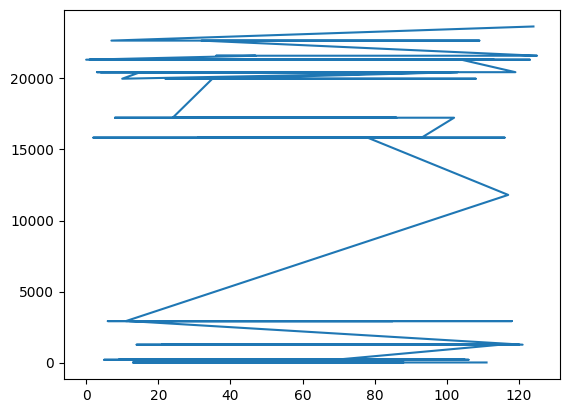

In [25]:
df['Size'] = df['Size'].replace(',', '', regex=True).astype(float).astype('Int64')

df["Size"].plot()

In [29]:
import pandas as pd
import os
import glob

def merge_csv_files(directory):
    # List to store individual dataframes
    dataframes = []

    # Use glob to get all CSV files in the directory
    csv_files = glob.glob(os.path.join(directory, "*.csv"))

    # Check if any CSV files were found
    if not csv_files:
        print(f"Warning: No CSV files found in directory: {directory}")
        return pd.DataFrame()  # Return an empty DataFrame if no files found

    for file_path in csv_files:
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Add a column with the file name
        df['Source File'] = os.path.basename(file_path)

        # Append to the list of dataframes
        dataframes.append(df)

    # Merge all dataframes
    merged_df = pd.concat(dataframes, ignore_index=True, sort=False)

    return merged_df

# Replace with the actual directory containing your CSV files
# directory = 'path/to/your/csv/files/'
directory = './'  # Use the current directory, for example

# Merge the CSV files
result = merge_csv_files(directory)



# Save the merged dataframe to a new CSV file
result.to_csv('merged_output.csv', index=False)
print("Merged CSV has been saved as 'merged_output.csv'")

# Print the number of files merged
print(f"Number of CSV files merged: {len(result['Source File'].unique())}")

Merged CSV has been saved as 'merged_output.csv'
Number of CSV files merged: 2


<ipython-input-30-cd2dbf6b7ea6>:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_df['DateTime'] = pd.to_datetime(merged_df['Start Date/Time']+" "+merged_df["Time"])


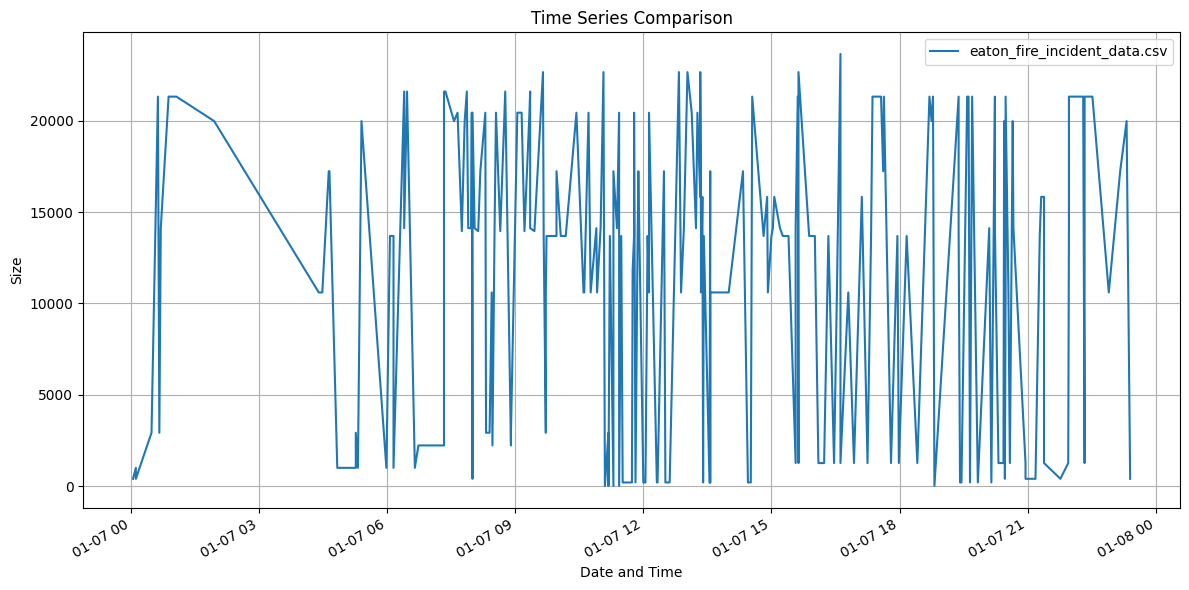

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from datetime import datetime

def read_and_merge_csv_files(directory):
    dataframes = []
    csv_files = glob.glob(os.path.join(directory, "*.csv"))

    for file_path in csv_files:
        df = pd.read_csv(file_path)
        df['Source File'] = os.path.basename(file_path)
        dataframes.append(df)

    merged_df = pd.concat(dataframes, ignore_index=True, sort=False)
    return merged_df

# Directory containing your CSV files
directory = 'path/to/your/csv/files/'

# Merge the CSV files
merged_df = pd.read_csv("merged_output.csv")
merged_df['Size'] = merged_df['Size'].replace(',', '', regex=True).astype(float).astype('Int64')
# Assuming your CSV files have 'DateTime' and 'Value' columns
# If they have different names, replace them in the following lines
merged_df['DateTime'] = pd.to_datetime(merged_df['Start Date/Time']+" "+merged_df["Time"])


merged_df.sort_values(by='DateTime', inplace=True)
# Create the plot
plt.figure(figsize=(12, 6))


plt.plot(merged_df['DateTime'], merged_df['Size'], label=file)

plt.title('Time Series Comparison')
plt.xlabel('Date and Time')
plt.ylabel('Size')
plt.legend()
plt.grid(True)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Show the plot
plt.tight_layout()
plt.show()

# Optionally, save the plot
# plt.savefig('time_series_comparison.png')


<ipython-input-31-1897b0dd4001>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_df['DateTime'] = pd.to_datetime(merged_df['Start Date/Time'] + " " + merged_df["Time"])


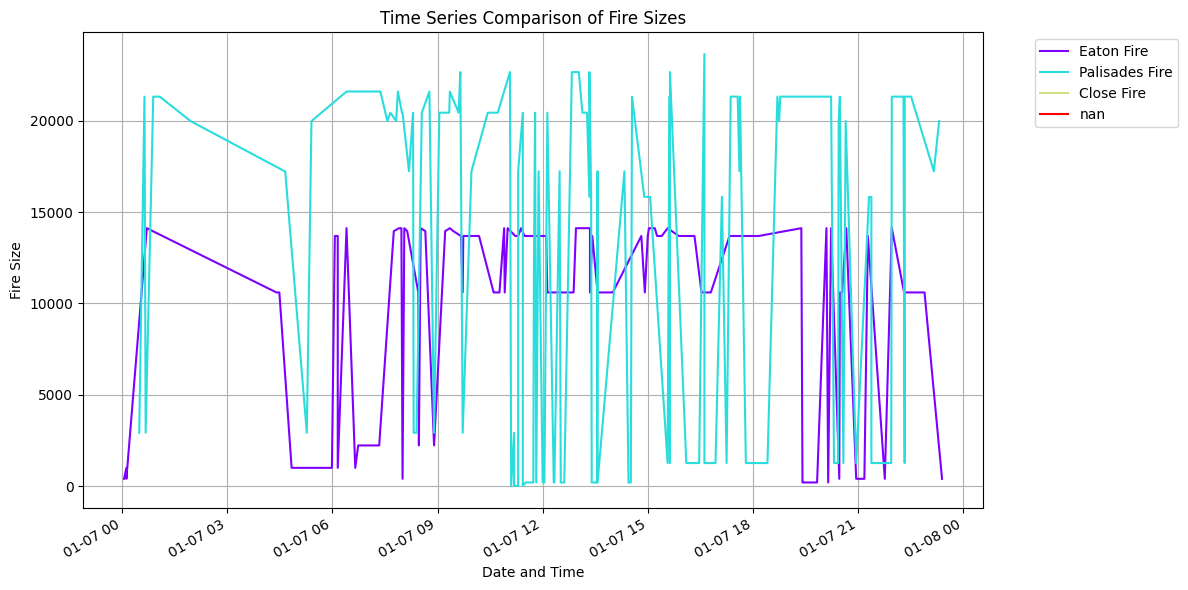

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the merged CSV file
merged_df = pd.read_csv("merged_output.csv")

# Convert DateTime
merged_df['DateTime'] = pd.to_datetime(merged_df['Start Date/Time'] + " " + merged_df["Time"])
merged_df['Size'] = merged_df['Size'].replace(',', '', regex=True).astype(float).astype('Int64')

# Sort the dataframe by DateTime
merged_df.sort_values(by='DateTime', inplace=True)

# Create a color map
unique_names = merged_df['Name'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_names)))
color_dict = dict(zip(unique_names, colors))

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each unique name with a different color
for name in unique_names:
    data = merged_df[merged_df['Name'] == name]
    plt.plot(data['DateTime'], data['Size'], label=name, color=color_dict[name])

plt.title('Time Series Comparison of Fire Sizes')
plt.xlabel('Date and Time')
plt.ylabel('Fire Size')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Optionally, save the plot
# plt.savefig('fire_size_comparison.png', bbox_inches='tight')


TypeError: 'value' must be an instance of str or bytes, not a float

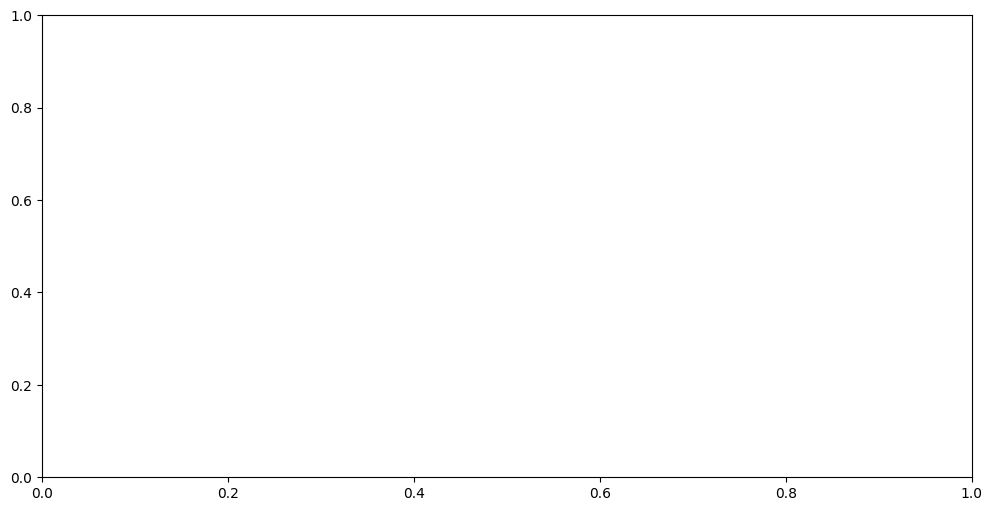

In [36]:

df =

# Sort the dataframe by DateTime
df.sort_values(by='DateTime', inplace=True)



# Create the plot
plt.figure(figsize=(12, 6))


plt.plot(df['DateTime'], df['Size'])

plt.title('Time Series Comparison of Fire Sizes')
plt.xlabel('Date and Time')
plt.ylabel('Fire Size')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Optionally, save the plot
# plt.savefig('fire_size_comparison.png', bbox_inches='tight')


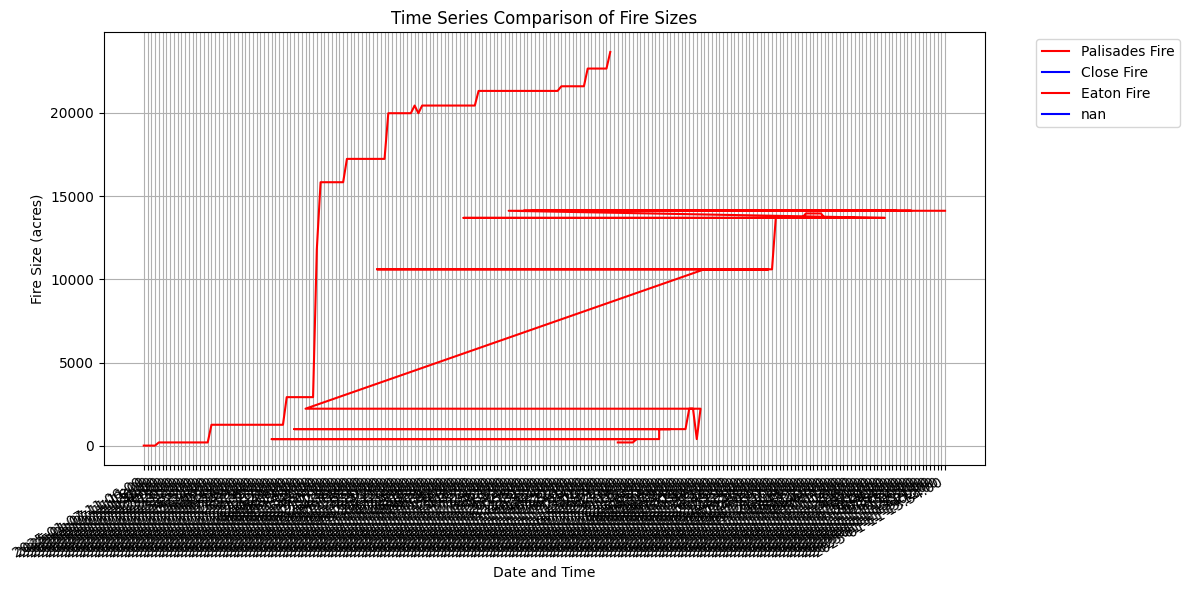

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the merged CSV file
merged_df = pd.read_csv("merged_output.csv")

# Convert DateTime
merged_df['Size'] = merged_df['Size'].replace(',', '', regex=True).astype(float).astype('Int64')

# Sort the dataframe by DateTime
merged_df.sort_values(by='DateTime', inplace=True)

# Create a color map with just two colors
unique_names = merged_df['Name'].unique()
colors = ['red', 'blue']
color_dict = {name: colors[i % 2] for i, name in enumerate(unique_names)}

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each unique name with one of the two colors
for name in unique_names:
    data = merged_df[merged_df['Name'] == name]
    plt.plot(data['DateTime'], data['Size'], label=name, color=color_dict[name])

plt.title('Time Series Comparison of Fire Sizes')
plt.xlabel('Date and Time')
plt.ylabel('Fire Size (acres)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Optionally, save the plot
# plt.savefig('fire_size_comparison.png', bbox_inches='tight')
